In [1]:
import random
from pathlib import Path
from math import sqrt, pi

import numpy as np
#from scipy.stats import ttest_rel, ttest_ind, wilcoxon
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
# Load in all csv result files & combine them to one pandas table
wells = ['C' + '{0:02d}'.format(x) for x in range(3,21)] + \
        ['D' + '{0:02d}'.format(x) for x in range(3,21)] + \
        ['E' + '{0:02d}'.format(x) for x in range(3,21)] + \
        ['F' + '{0:02d}'.format(x) for x in range(3,21)] + \
        ['G' + '{0:02d}'.format(x) for x in range(3,21)] + \
        ['H' + '{0:02d}'.format(x) for x in range(3,21)]

base_path = '/Users/Joel/shares/workShareJoel/20190125-PbodyDissolution-bDNA-FISH-feature-values/20190125-PbodyDissolution-bDNA-FISH_p1_'

results = pd.DataFrame()

for well in wells:
    curr_features = pd.read_csv(base_path + well + '_Cells_feature-values.csv')
    curr_metadata = pd.read_csv(base_path + well + '_Cells_metadata.csv')
    curr_well = curr_features.merge(curr_metadata, on = ['mapobject_id'])
    results = pd.concat([results, curr_well])

# print(results.head())
print(results.columns.values)

['mapobject_id' 'Nuclei_Intensity_max_DAPI' 'Nuclei_Intensity_mean_DAPI'
 'Nuclei_Intensity_min_DAPI' 'Nuclei_Intensity_sum_DAPI'
 'Nuclei_Intensity_std_DAPI' 'Intensity_max_DAPI' 'Intensity_mean_DAPI'
 'Intensity_min_DAPI' 'Intensity_sum_DAPI' 'Intensity_std_DAPI'
 'Intensity_max_Succs' 'Intensity_mean_Succs' 'Intensity_min_Succs'
 'Intensity_sum_Succs' 'Intensity_std_Succs' 'Intensity_max_DDX6'
 'Intensity_mean_DDX6' 'Intensity_min_DDX6' 'Intensity_sum_DDX6'
 'Intensity_std_DDX6' 'Intensity_max_bDNA_FISH' 'Intensity_mean_bDNA_FISH'
 'Intensity_min_bDNA_FISH' 'Intensity_sum_bDNA_FISH'
 'Intensity_std_bDNA_FISH' 'mRNA_Count_bDNA_FISH'
 'mRNA_Mean_Intensity_max_bDNA_FISH' 'mRNA_Mean_Intensity_mean_bDNA_FISH'
 'mRNA_Mean_Intensity_min_bDNA_FISH' 'mRNA_Mean_Intensity_std_bDNA_FISH'
 'mRNA_Mean_Intensity_sum_bDNA_FISH' 'mRNA_Std_Intensity_max_bDNA_FISH'
 'mRNA_Std_Intensity_mean_bDNA_FISH' 'mRNA_Std_Intensity_min_bDNA_FISH'
 'mRNA_Std_Intensity_std_bDNA_FISH' 'mRNA_Std_Intensity_sum_bDNA_F

In [25]:
# Add the treatment conditions as variables
results = results.assign(treatment = results['well_name'])
treatments = ['DMEM 5\'', 'Hex 2\'', 'Hex 5\'', 'Hex 10\'', 'CHX 15\'', 'DMEM 15\'', 'Puro 15\'', 'CHX 30\'', 'DMEM 30\'', 'Puro 30\'', 'CHX 40\'', 'CHX 1h', 'Ctrl 1h', 'Puro 1h', 'ActD 1h', 'ActD 4h', 'Ctrl 4h', 'no probe']
rows = ['C', 'D', 'E', 'F', 'G', 'H']
mapping = {}

for row in rows:
    wells = [row + '{0:02d}'.format(x) for x in range(3,21)]
    for i, treatment in enumerate(treatments):
        mapping[wells[i]] = treatment

results = results.replace({'treatment' : mapping})

mapping = {}
results = results.assign(probe = results['well_name'])
probes = ['HPRT', 'Lamp1', 'CCND1', 'HIF1A', 'CLTCL1', 'dapB']
for i, row in enumerate(rows):
    wells = [row + '{0:02d}'.format(x) for x in range(3,21)]
    for well in wells:
        mapping[well] = probes[i]

results = results.replace({'probe' : mapping})

# Add a time variable (time of treatment / Ctrl)
timepoint = [5,2,5,10,15,15,15,30,30,30,40,60,60,60,60,240,240,0]
mapping = {}
results = results.assign(timepoint = results['well_name'])
for row in rows:
    wells = [row + '{0:02d}'.format(x) for x in range(3,21)]
    for i, tp in enumerate(timepoint):
        mapping[wells[i]] = tp

results = results.replace({'timepoint' : mapping})

# Add treatment type
results = results.assign(treatment_type = results['well_name'])
treatments_types = ['Control', 'Hex', 'Hex', 'Hex', 'CHX', 'Control', 'Puro', 'CHX', 'Control', 'Puro', 'CHX', 'CHX', 'Control', 'Puro', 'ActD', 'ActD', 'Control', 'no probe']
mapping = {}

for row in rows:
    wells = [row + '{0:02d}'.format(x) for x in range(3,21)]
    for i, treatment_type in enumerate(treatments_types):
        mapping[wells[i]] = treatment_type

results = results.replace({'treatment_type' : mapping})


Filtered out 231138 cells, kept 394310 (63.04%)
Percentage removed by FISH-Blobs SVM: 1.79%
Percentage removed by Missegmented SVM: 6.67%
Percentage removed by Mitotic SVM: 4.81%
Percentage border cells: 29.07%


Text(0.5, 1.0, '% of cells that pass QC')

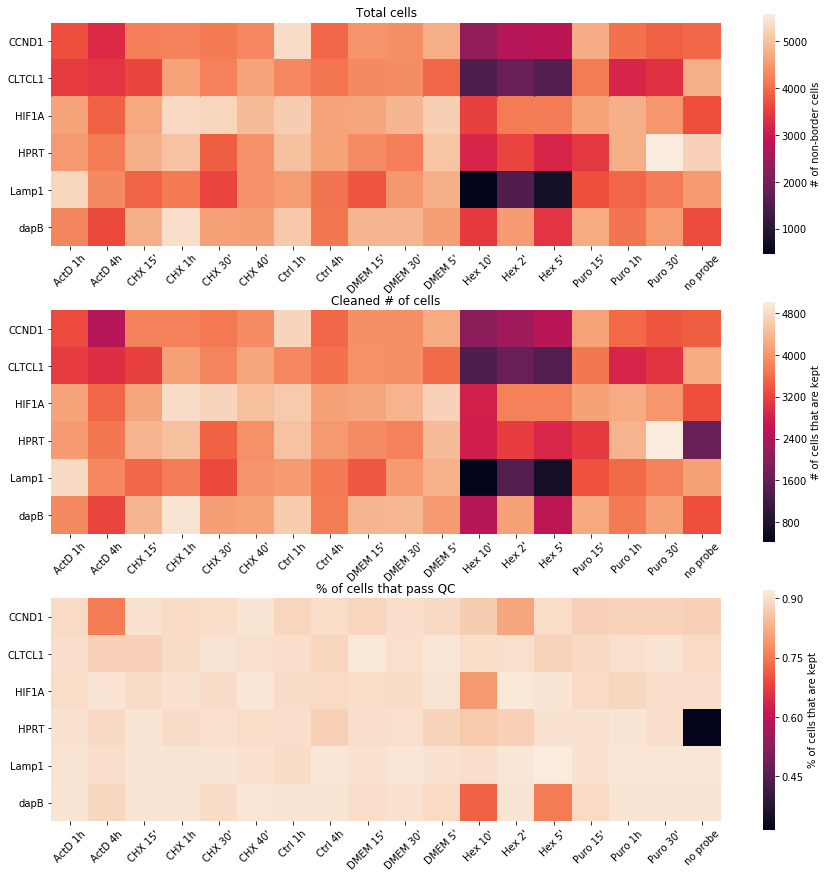

In [26]:
# Filter out cells that are thrown out by SVM
SVMs = ['FISH-Blobs', 'Missegmented', 'Mitotic'] # 0 are the values to be kept
cells_to_keep = (results['is_border'] == 0)
for svm in SVMs:
    cells_to_keep = cells_to_keep & (results[svm] == 0)
    
# no_blobs = (results['FISH-Blobs'] == 0)
# correct_segment = (results['Missegmented'] == 0)
# non_mitotic = (results['Mitotic'] == 0)
# non_border_cells = (results['is_border'] == 0)
# Filter out cells that have very low DAPI signal. Mostly missegmented HEK cells
normal_dapi = (results['Nuclei_Intensity_sum_DAPI'] < 10000000) & (results['Nuclei_Intensity_sum_DAPI'] > 1500000)
# Filter out huge cells (missegmented cells)
normal_area = (results['Morphology_Area'] < 125000)

cells_to_keep = cells_to_keep & normal_dapi & normal_area

results_cleaned = results.loc[cells_to_keep]
results = results.assign(cells_to_keep = cells_to_keep.astype(int))

print('Filtered out {} cells, kept {} ({:.2f}%)'.format(results.shape[0] - results_cleaned.shape[0], 
                                                        results_cleaned.shape[0], results_cleaned.shape[0]
                                                        /results.shape[0] *100))

# Give some statistics about how much was filtered out
for svm in SVMs:
    filtered_out = (results[svm] == 0)
    print('Percentage removed by {} SVM: {:.2f}%'.format(svm, (results.shape[0] - sum(filtered_out))/results.shape[0]*100))

border_cells = (results['is_border'] == 0)
print('Percentage border cells: {:.2f}%'.format((results.shape[0] - sum(border_cells))/results.shape[0]*100))


# Make a heatmap of removed cells: Create a corresponding pivot table first
# xticks = ['DMEM 5\'', 'Hex 2\'', 'Hex 5\'', 'Hex 10\'', 'CHX 15\'', 'DMEM 15\'', 'Puro 15\'', 'CHX 30\'', 'DMEM 30\'', 'Puro 30\'', 'CHX 40\'', 'CHX 1h', 'Ctrl 1h', 'Puro 1h', 'ActD 1h', 'ActD 4h', 'Ctrl 4h', 'no probe']
# yticks = ['HPRT', 'Lamp1', 'CCND1', 'HIF1A', 'CLTCL1', 'dapB']

non_border_cells = (results['is_border'] == 0)
results_heatmap = results.loc[non_border_cells]
results_heatmap = results_heatmap.assign(row = results_heatmap['well_name'].str.slice(stop = 1))
results_heatmap = results_heatmap.assign(col = results_heatmap['well_name'].str.slice(start = 1))
results_heatmap = results_heatmap.assign(non_border = (results_heatmap['is_border'] == 0).astype(int))

piv_percentage_cells_to_keep = pd.pivot_table(results_heatmap, values = 'cells_to_keep', index = 'probe', columns =['treatment'])
piv_nb_non_border_cells = pd.pivot_table(results_heatmap, values = 'non_border', index = 'probe', columns =['treatment'], aggfunc = 'sum')
piv_nb_ncells_to_keep = pd.pivot_table(results_heatmap, values = 'cells_to_keep', index = 'probe', columns =['treatment'], aggfunc = 'sum')


fig1, ax1 = plt.subplots(3, 1, figsize=(15, 15))
g = sns.heatmap(piv_nb_non_border_cells, square = True, ax = ax1[0], cbar_kws={'label': '# of non-border cells'}) # , xticklabels=xticks, yticklabels = yticks
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
g.set_xticklabels(g.get_xticklabels(), rotation = 45)
g.set_ylabel('')
g.set_xlabel('')

h = sns.heatmap(piv_nb_ncells_to_keep, square = True, ax = ax1[1], cbar_kws={'label': '# of cells that are kept'})
h.set_yticklabels(h.get_yticklabels(), rotation = 0)
h.set_xticklabels(h.get_xticklabels(), rotation = 45)
h.set_ylabel('')
h.set_xlabel('')

l = sns.heatmap(piv_percentage_cells_to_keep, square = True, ax = ax1[2], cbar_kws={'label': '% of cells that are kept'})
l.set_yticklabels(l.get_yticklabels(), rotation = 0)
l.set_xticklabels(l.get_xticklabels(), rotation = 45)
l.set_ylabel('')
l.set_xlabel('')

ax1[0].set_title('Total cells')
ax1[1].set_title('Cleaned # of cells')
ax1[2].set_title('% of cells that pass QC')


In [27]:
# Define well sub-selections
wells_HPRT = ['C' + '{0:02d}'.format(x) for x in range(3,21)]
wells_Lamp1 = ['D' + '{0:02d}'.format(x) for x in range(3,21)]
wells_CCND1 = ['E' + '{0:02d}'.format(x) for x in range(3,21)]
wells_HIF1A = ['F' + '{0:02d}'.format(x) for x in range(3,21)]
wells_CLTCL1 = ['G' + '{0:02d}'.format(x) for x in range(3,21)]
wells_dapB = ['H' + '{0:02d}'.format(x) for x in range(3,21)]

wells_controls_HPRT = ['C' + '{0:02d}'.format(x) for x in [3, 8, 11, 15, 19, 20]]
wells_controls_Lamp1 = ['D' + '{0:02d}'.format(x) for x in [3, 8, 11, 15, 19, 20]]
wells_controls_CCND1 = ['E' + '{0:02d}'.format(x) for x in [3, 8, 11, 15, 19, 20]]
wells_controls_HIF1A = ['F' + '{0:02d}'.format(x) for x in [3, 8, 11, 15, 19, 20]]
wells_controls_CLTCL1 = ['G' + '{0:02d}'.format(x) for x in [3, 8, 11, 15, 19, 20]]
wells_controls_dapB = ['H' + '{0:02d}'.format(x) for x in [3, 8, 11, 15, 19, 20]]

wells_chx_HPRT = ['C' + '{0:02d}'.format(x) for x in [7, 10, 13, 14]]
wells_chx_Lamp1 = ['D' + '{0:02d}'.format(x) for x in [7, 10, 13, 14]]
wells_chx_CCND1 = ['E' + '{0:02d}'.format(x) for x in [7, 10, 13, 14]]
wells_chx_HIF1A = ['F' + '{0:02d}'.format(x) for x in [7, 10, 13, 14]]
wells_chx_CLTCL1 = ['G' + '{0:02d}'.format(x) for x in [7, 10, 13, 14]]
wells_chx_dapB = ['H' + '{0:02d}'.format(x) for x in [7, 10, 13, 14]]

results_HPRT = (results_cleaned['well_name'].isin(wells_HPRT))
results_Lamp1 = (results_cleaned['well_name'].isin(wells_Lamp1))
results_CCND1 = (results_cleaned['well_name'].isin(wells_CCND1))
results_HIF1A = (results_cleaned['well_name'].isin(wells_HIF1A))
results_CLTCL1 = (results_cleaned['well_name'].isin(wells_CLTCL1))
results_dapB = (results_cleaned['well_name'].isin(wells_dapB))

results_controls_HPRT = (results_cleaned['well_name'].isin(wells_controls_HPRT))
results_controls_Lamp1 = (results_cleaned['well_name'].isin(wells_controls_Lamp1))
results_controls_CCND1 = (results_cleaned['well_name'].isin(wells_controls_CCND1))
results_controls_HIF1A = (results_cleaned['well_name'].isin(wells_controls_HIF1A))
results_controls_CLTCL1 = (results_cleaned['well_name'].isin(wells_controls_CLTCL1))
results_controls_dapB = (results_cleaned['well_name'].isin(wells_controls_dapB))

results_chx_HPRT = (results_cleaned['well_name'].isin(wells_chx_HPRT))
results_chx_Lamp1 = (results_cleaned['well_name'].isin(wells_chx_Lamp1))
results_chx_CCND1 = (results_cleaned['well_name'].isin(wells_chx_CCND1))
results_chx_HIF1A = (results_cleaned['well_name'].isin(wells_chx_HIF1A))
results_chx_CLTCL1 = (results_cleaned['well_name'].isin(wells_chx_CLTCL1))
results_chx_dapB = (results_cleaned['well_name'].isin(wells_chx_dapB))

Text(0.5, 187.7181818181819, '')

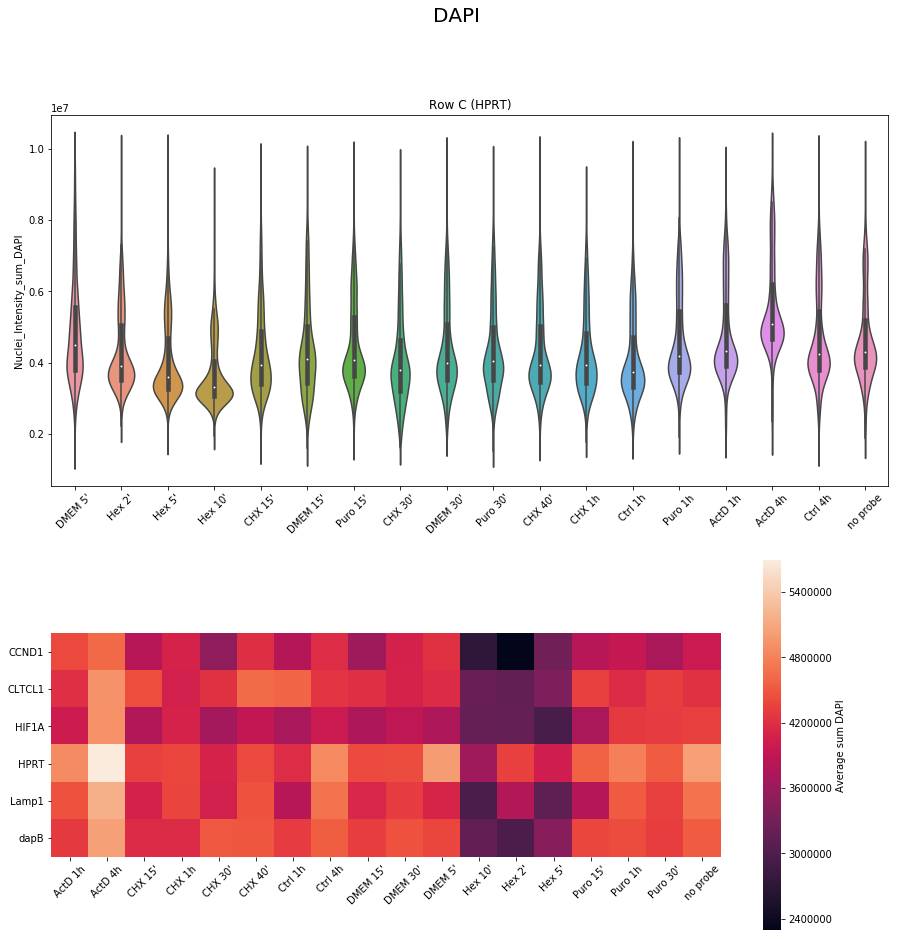

In [7]:
# Make some quality control plots
# DAPI violin plots
piv_dapi = pd.pivot_table(results_heatmap, values = 'Nuclei_Intensity_sum_DAPI', index = 'probe', columns =['treatment'])

fig1, ax1 = plt.subplots(2, 1, figsize=(15, 15))
fig1.suptitle('DAPI', fontsize = 20)
g = sns.violinplot(x = 'treatment', y = 'Nuclei_Intensity_sum_DAPI', data = results_cleaned.loc[results_HPRT], ax=ax1[0])
g.set_xticklabels(g.get_xticklabels(), rotation = 45)
g.set_xlabel('')
ax1[0].set_title('Row C (HPRT)')

# h = sns.violinplot(x = 'treatment', y = 'Nuclei_Intensity_sum_DAPI', data = results_cleaned.loc[results_dapB], ax=ax1[1])
# h.set_xticklabels(h.get_xticklabels(), rotation = 45)
# h.set_xlabel('')

l = sns.heatmap(piv_dapi, square = True, ax = ax1[1], cbar_kws={'label': 'Average sum DAPI'})
l.set_yticklabels(l.get_yticklabels(), rotation = 0)
l.set_xticklabels(l.get_xticklabels(), rotation = 45)
l.set_ylabel('')
l.set_xlabel('')




Text(0.5, 187.7181818181819, '')

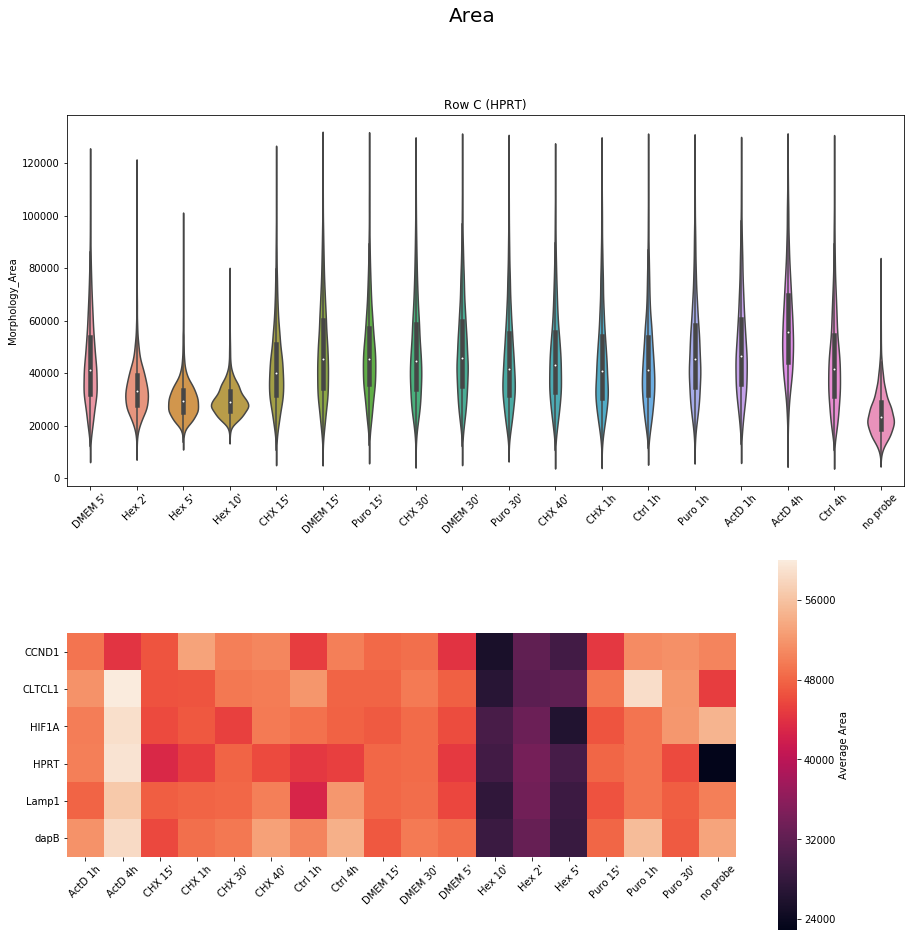

In [8]:
# Area violin plots
piv_area = pd.pivot_table(results_heatmap, values = 'Morphology_Area', index = 'probe', columns =['treatment'])

fig2, ax2 = plt.subplots(2, 1, figsize=(15, 15))
fig2.suptitle('Area', fontsize = 20)
g = sns.violinplot(x = 'treatment', y = 'Morphology_Area', data = results_cleaned.loc[results_HPRT], ax=ax2[0])
g.set_xticklabels(g.get_xticklabels(), rotation = 45)
g.set_xlabel('')
ax2[0].set_title('Row C (HPRT)')

# h = sns.violinplot(x = 'treatment', y = 'Morphology_Area', data = results_cleaned.loc[results_dapB], ax=ax2[1])
# h.set_xticklabels(h.get_xticklabels(), rotation = 45)
# h.set_xlabel('')

l = sns.heatmap(piv_area, square = True, ax = ax2[1], cbar_kws={'label': 'Average Area'})
l.set_yticklabels(l.get_yticklabels(), rotation = 0)
l.set_xticklabels(l.get_xticklabels(), rotation = 45)
l.set_ylabel('')
l.set_xlabel('')


(-10, 300)

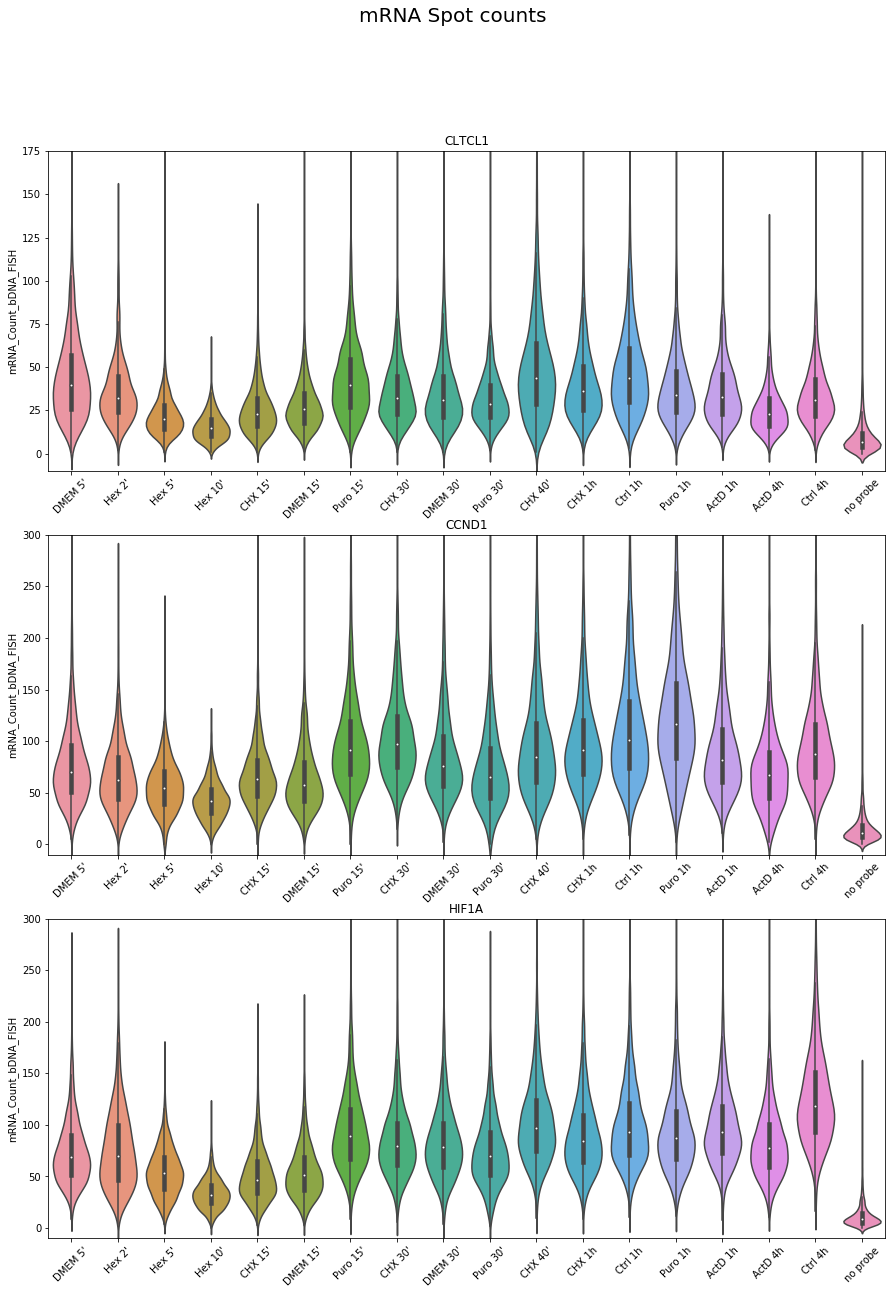

In [9]:
# plot transcript numbers per cell, comparing replicates
fig1, ax1 = plt.subplots(3, 1, figsize=(15, 20))
fig1.suptitle('mRNA Spot counts', fontsize = 20)
g = sns.violinplot(x = 'treatment', y = 'mRNA_Count_bDNA_FISH', data = results_cleaned.loc[results_CLTCL1], ax=ax1[0], scale = 'width')
ax1[0].set_title('CLTCL1')
g.set_xticklabels(g.get_xticklabels(), rotation = 45)
g.set_xlabel('')
h = sns.violinplot(x = 'treatment', y = 'mRNA_Count_bDNA_FISH', data = results_cleaned.loc[results_CCND1], ax=ax1[1], scale = 'width', cbar_kws={'label': 'CCND1'})
ax1[1].set_title('CCND1')
h.set_xticklabels(h.get_xticklabels(), rotation = 45)
h.set_xlabel('')

h = sns.violinplot(x = 'treatment', y = 'mRNA_Count_bDNA_FISH', data = results_cleaned.loc[results_HIF1A], ax=ax1[2], scale = 'width', cbar_kws={'label': 'CCND1'})
ax1[2].set_title('HIF1A')
h.set_xticklabels(h.get_xticklabels(), rotation = 45)
h.set_xlabel('')

ax1[0].set_ylim(-10,175)
ax1[1].set_ylim(-10,300)
ax1[2].set_ylim(-10,300)


(-10, 300)

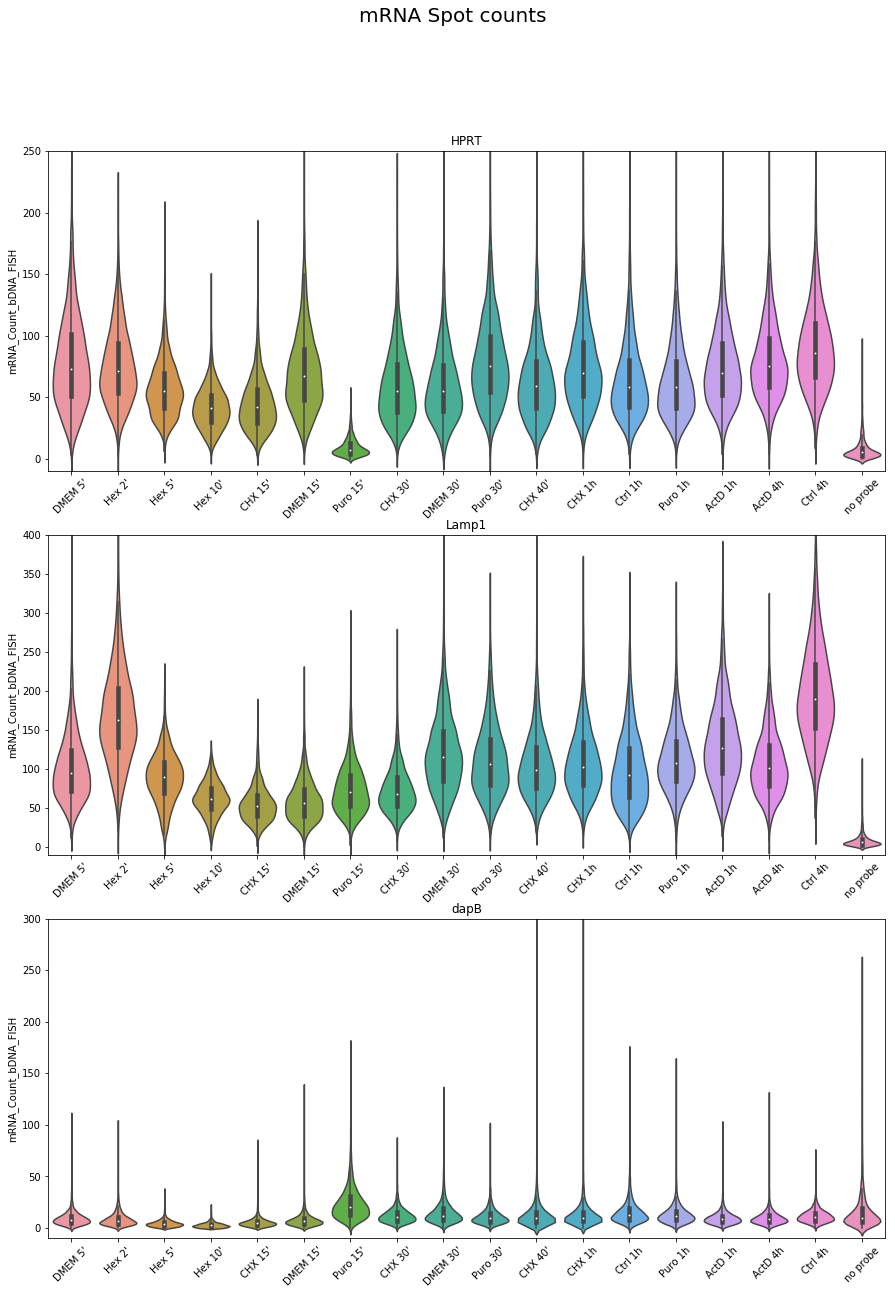

In [10]:
# plot transcript numbers per cell, comparing replicates
fig1, ax1 = plt.subplots(3, 1, figsize=(15, 20))
fig1.suptitle('mRNA Spot counts', fontsize = 20)
g = sns.violinplot(x = 'treatment', y = 'mRNA_Count_bDNA_FISH', data = results_cleaned.loc[results_HPRT], ax=ax1[0], scale = 'width')
ax1[0].set_title('HPRT')
g.set_xticklabels(g.get_xticklabels(), rotation = 45)
g.set_xlabel('')
h = sns.violinplot(x = 'treatment', y = 'mRNA_Count_bDNA_FISH', data = results_cleaned.loc[results_Lamp1], ax=ax1[1], scale = 'width', cbar_kws={'label': 'CCND1'})
ax1[1].set_title('Lamp1')
h.set_xticklabels(h.get_xticklabels(), rotation = 45)
h.set_xlabel('')

h = sns.violinplot(x = 'treatment', y = 'mRNA_Count_bDNA_FISH', data = results_cleaned.loc[results_dapB], ax=ax1[2], scale = 'width', cbar_kws={'label': 'CCND1'})
ax1[2].set_title('dapB')
h.set_xticklabels(h.get_xticklabels(), rotation = 45)
h.set_xlabel('')

ax1[0].set_ylim(-10,250)
ax1[1].set_ylim(-10,400)
ax1[2].set_ylim(-10,300)



(-10, 300)

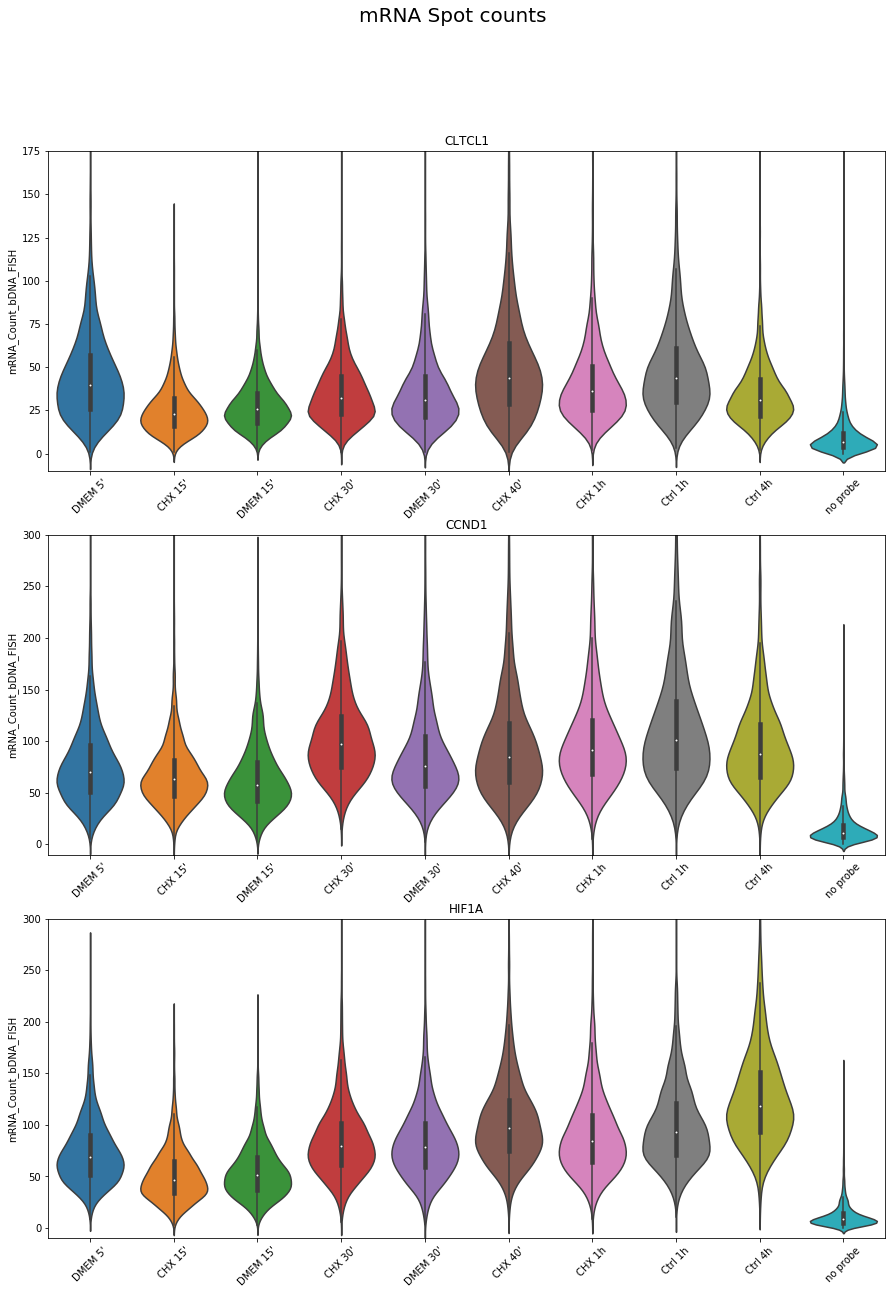

In [11]:
# plot transcript numbers per cell, comparing replicates
fig1, ax1 = plt.subplots(3, 1, figsize=(15, 20))
fig1.suptitle('mRNA Spot counts', fontsize = 20)
g = sns.violinplot(x = 'treatment', y = 'mRNA_Count_bDNA_FISH', data = results_cleaned.loc[results_controls_CLTCL1 | results_chx_CLTCL1], ax=ax1[0], scale = 'width', cbar_kws={'label': 'CLTCL1'})
ax1[0].set_title('CLTCL1')
g.set_xticklabels(g.get_xticklabels(), rotation = 45)
g.set_xlabel('')
h = sns.violinplot(x = 'treatment', y = 'mRNA_Count_bDNA_FISH', data = results_cleaned.loc[results_controls_CCND1 | results_chx_CCND1], ax=ax1[1], scale = 'width', cbar_kws={'label': 'CCND1'})
ax1[1].set_title('CCND1')
h.set_xticklabels(h.get_xticklabels(), rotation = 45)
h.set_xlabel('')

l = sns.violinplot(x = 'treatment', y = 'mRNA_Count_bDNA_FISH', data = results_cleaned.loc[results_controls_HIF1A | results_chx_HIF1A], ax=ax1[2], scale = 'width', cbar_kws={'label': 'CCND1'})
ax1[2].set_title('HIF1A')
l.set_xticklabels(h.get_xticklabels(), rotation = 45)
l.set_xlabel('')

ax1[0].set_ylim(-10,175)
ax1[1].set_ylim(-10,300)
ax1[2].set_ylim(-10,300)


(-2, 45)

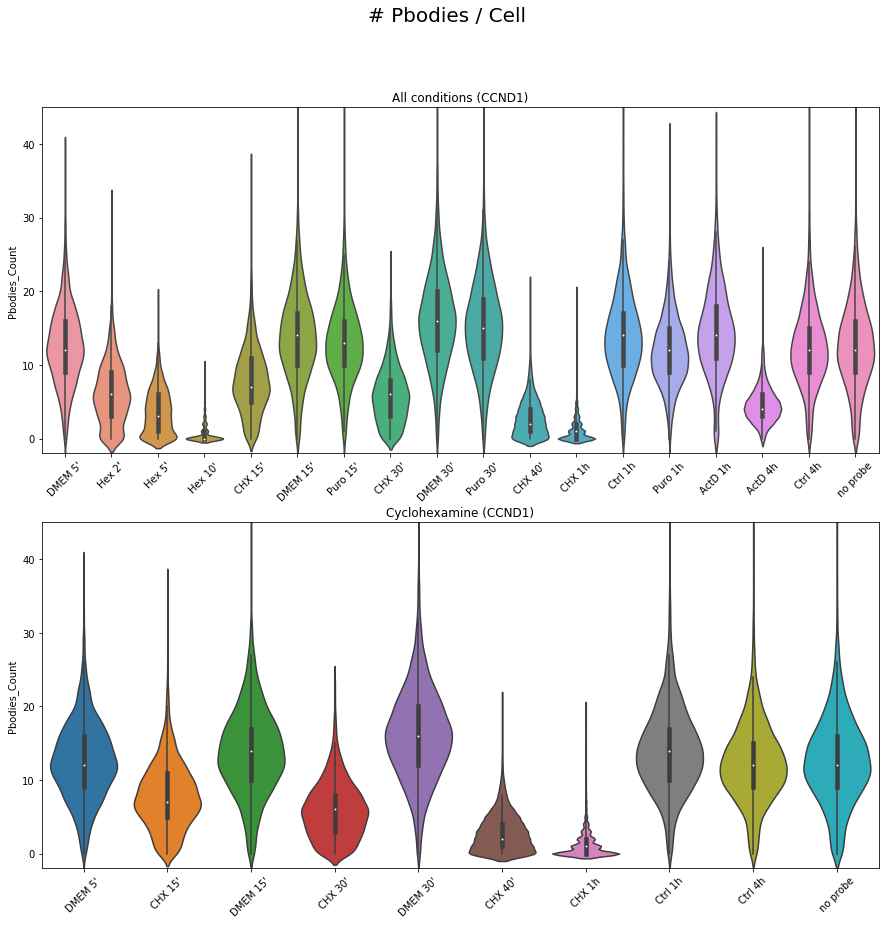

In [12]:
# Look at P-body numbers per cell
fig1, ax1 = plt.subplots(2, 1, figsize=(15, 14))
fig1.suptitle('# Pbodies / Cell', fontsize = 20)
g = sns.violinplot(x = 'treatment', y = 'Pbodies_Count', data = results_cleaned.loc[results_CCND1], ax=ax1[0], scale = 'width', cbar_kws={'label': 'CLTCL1'})
ax1[0].set_title('All conditions (CCND1)')
g.set_xticklabels(g.get_xticklabels(), rotation = 45)
g.set_xlabel('')

h = sns.violinplot(x = 'treatment', y = 'Pbodies_Count', data = results_cleaned.loc[results_controls_CCND1 | results_chx_CCND1], ax=ax1[1], scale = 'width', cbar_kws={'label': 'CLTCL1'})
ax1[1].set_title('Cyclohexamine (CCND1)')
h.set_xticklabels(h.get_xticklabels(), rotation = 45)
h.set_xlabel('')

ax1[0].set_ylim(-2,45)
ax1[1].set_ylim(-2,45)


(-50, 1500)

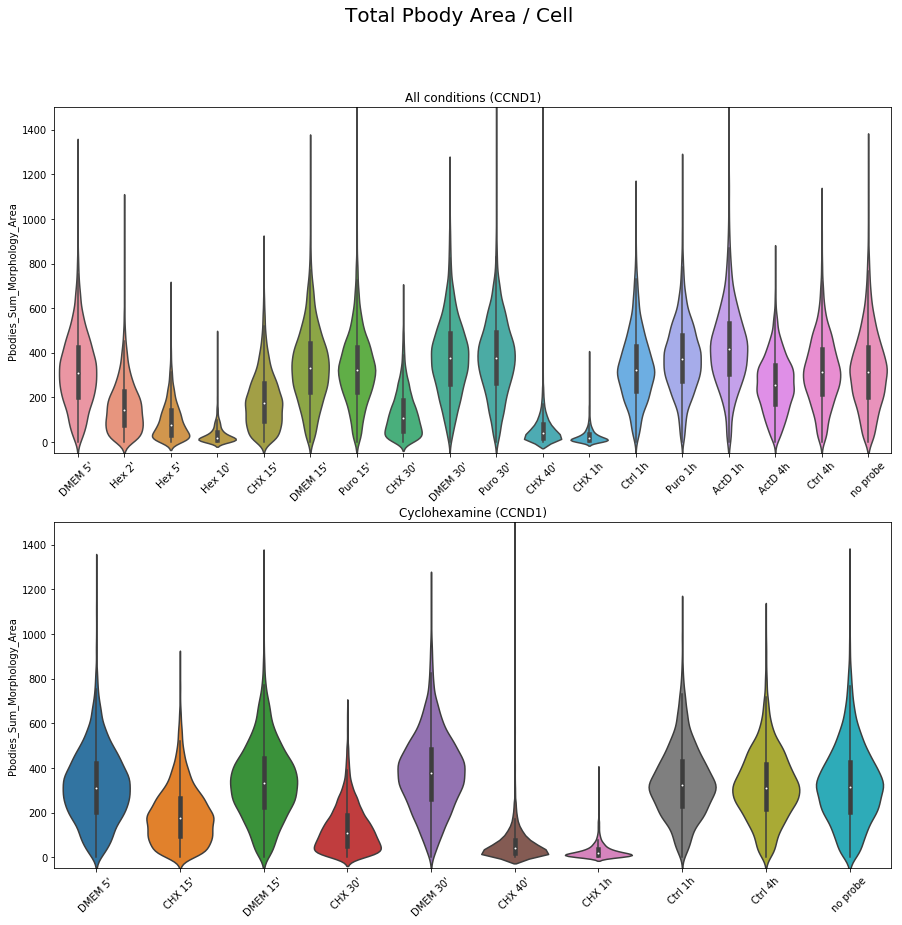

In [13]:
# Look at P-body area per cell
fig1, ax1 = plt.subplots(2, 1, figsize=(15, 14))
fig1.suptitle('Total Pbody Area / Cell', fontsize = 20)
g = sns.violinplot(x = 'treatment', y = 'Pbodies_Sum_Morphology_Area', data = results_cleaned.loc[results_CCND1], ax=ax1[0], scale = 'width', cbar_kws={'label': 'CLTCL1'})
ax1[0].set_title('All conditions (CCND1)')
g.set_xticklabels(g.get_xticklabels(), rotation = 45)
g.set_xlabel('')

h = sns.violinplot(x = 'treatment', y = 'Pbodies_Sum_Morphology_Area', data = results_cleaned.loc[results_controls_CCND1 | results_chx_CCND1], ax=ax1[1], scale = 'width', cbar_kws={'label': 'CLTCL1'})
ax1[1].set_title('Cyclohexamine (CCND1)')
h.set_xticklabels(h.get_xticklabels(), rotation = 45)
h.set_xlabel('')

ax1[0].set_ylim(-50,1500)
ax1[1].set_ylim(-50,1500)


In [86]:
# Calculate average spot counts per well 
print(results_cleaned.groupby('well_name')['mRNA_Count_bDNA_FISH'].median())

# print(results_cleaned.groupby('well_name')['mRNA_Pbody_Count'].mean())

well_name
C03     73.0
C04     71.0
C05     55.0
C06     41.0
C07     42.0
C08     67.0
C09      7.0
C10     55.0
C11     55.0
C12     75.0
C13     59.0
C14     70.0
C15     58.0
C16     58.0
C17     70.0
C18     75.0
C19     86.0
C20      5.0
D03     95.0
D04    163.0
D05     90.0
D06     62.0
D07     52.0
D08     56.0
D09     70.0
D10     68.0
D11    115.0
D12    106.0
D13     99.0
D14    103.0
       ...  
G09     40.0
G10     32.0
G11     31.0
G12     29.0
G13     44.0
G14     36.0
G15     44.0
G16     34.0
G17     33.0
G18     23.0
G19     31.0
G20      7.0
H03      8.0
H04      7.0
H05      4.0
H06      3.0
H07      5.0
H08      7.0
H09     20.5
H10     11.0
H11     12.0
H12     10.0
H13     10.0
H14     10.0
H15     13.0
H16     12.0
H17      9.0
H18      9.0
H19     11.0
H20     10.0
Name: mRNA_Count_bDNA_FISH, Length: 108, dtype: float64


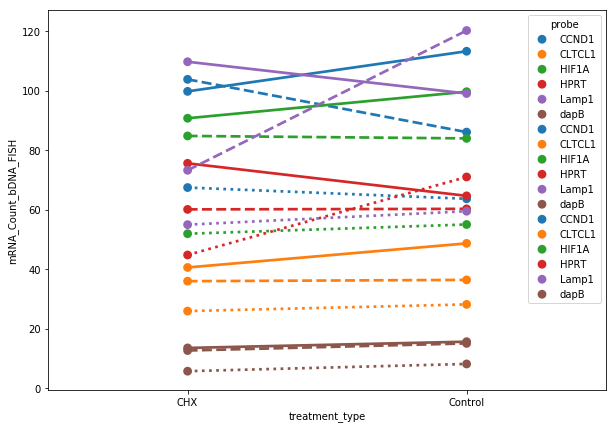

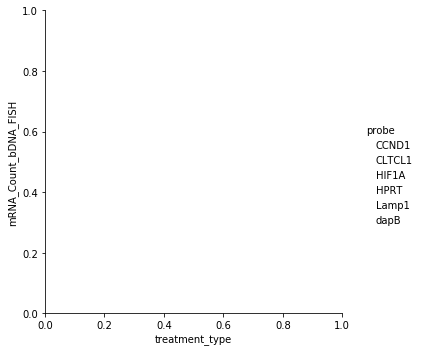

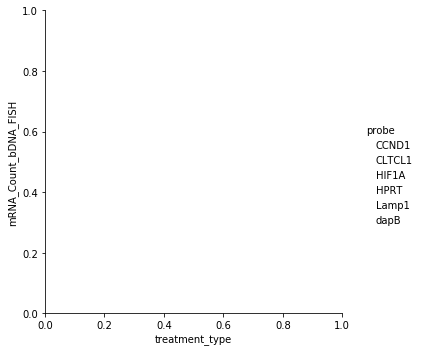

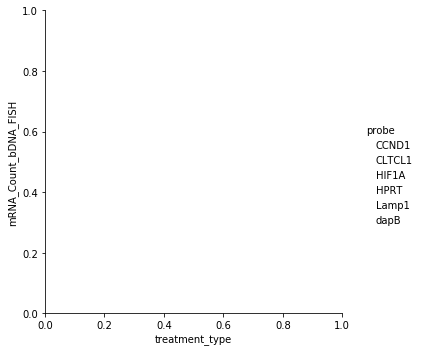

In [58]:
# Make a catplot of mean # transcripts Ctrl vs. CHX treatment (different times)
# timepoint
# treatment_type
# mRNA_Count_bDNA_FISH

# Reduce dataset to only CHX & Controls where both are available
wells_chx = ['C' + '{0:02d}'.format(x) for x in [7, 8, 10, 11, 14, 15]] + \
            ['D' + '{0:02d}'.format(x) for x in [7, 8, 10, 11, 14, 15]] + \
            ['E' + '{0:02d}'.format(x) for x in [7, 8, 10, 11, 14, 15]] + \
            ['F' + '{0:02d}'.format(x) for x in [7, 8, 10, 11, 14, 15]] + \
            ['G' + '{0:02d}'.format(x) for x in [7, 8, 10, 11, 14, 15]] + \
            ['H' + '{0:02d}'.format(x) for x in [7, 8, 10, 11, 14, 15]]

results_chx = results_cleaned.loc[(results_cleaned['well_name'].isin(wells_chx))]
group_results = results_chx.groupby(['treatment_type', 'timepoint', 'probe'])['mRNA_Count_bDNA_FISH'].mean().reset_index()
# print(group_results)

fig1, ax1 = plt.subplots(1, 1, figsize=(10, 7))
linestyle = [':', "--", "-"]

timepoints = [15, 30, 60]
for i, tp in enumerate(timepoints):
    curr_data = group_results.loc[(group_results['timepoint'] == tp)]
    sns.catplot(x = 'treatment_type', y = 'mRNA_Count_bDNA_FISH', hue = 'probe', linestyles = linestyle[i], kind = 'point', data = curr_data, ax = ax1)


# piv_chx = pd.pivot_table(results_chx, values = 'mRNA_Count_bDNA_FISH', index = 'treatment_type', columns =['timepoint', 'probe'])
# print(piv_chx)
#sns.catplot(x = 'treatment_type', y = 'mRNA_Count_bDNA_FISH', hue = 'timepoint', data = results_chx)


In [13]:
# Save dataframe as csv
# results_cleaned.to_csv('20181203-bDNA-FISH8-results-cleaned_improved.csv')

Load data directly from TissueMaps for single wells

In [16]:
# Evaluate pipeline parameters
import tmclient
host="172.23.47.46"
port = 80
experimentName="20190125-PbodyDissolution-bDNA-FISH"
username="joel"
password="123456"
mapobject="Cells"
client = tmclient.TmClient(host, port, username, password, experimentName)

plateDownload = client.get_plates()
plate_name = plateDownload[0]['name']

wells = ['C03', 'C07', 'C11', 'D03', 'G03', 'H03', 'H04', 'C20', 'D20', 'E20']
for well in wells:
    print(well)
    site_y = 0
    site_x = 1
    feature_values = client.download_feature_values(mapobject, plate_name, well, site_y, site_x)
    #print(feature_values.columns.values)
    print(feature_values['mRNA_Count_bDNA_FISH'].mean())
    print(feature_values['mRNA_Count_bDNA_FISH'].median())


C03
73.32885906040268
67.0
C07
48.92253521126761
48.5
C11
74.90123456790124
74.0
D03
90.99
87.0
G03
50.71653543307087
43.0
H03
9.312056737588652
8.0
H04
12.13138686131387
11.0
C20
7.076923076923077
4.0
D20
8.25438596491228
6.0
E20
12.842105263157896
11.0
